<br> </br><br> </br>
<br> </br><br> </br>

# <center> Reinforcement Learning Project: Lunar Lander </center>


<br> </br><br> </br>
<br> </br><br> </br>
<br> </br>
<br> 
<br>
<br>
<br>
<br> 
<br>
<br>
<br>


##  <center> Table of Contents </center>
<br> </br><br> </br>

[ **1 ) Abstract**](#content1)

[ **2 ) Prerequisites**](#content2)

[ **3 ) Algorithm**](#content3)

[ **4 ) OpenAI**](#content4)

[ **5 ) Architecture**](#content5)

[ **6 ) Loss Function**](#content6)

[ **7 ) Training**](#content7)

[ **8 ) Performance Analysis**](#content8)

[ **9 ) Observation**](#content9)

[ **10 ) Conclusion**](#content10)

<br>

<br>

***
***
***

<br> 
<br>
<br>
<br>
<br> 
<br>
<br>
<br>


<a id="content1"></a>
## 1. Abstract

<div style="text-align: justify; font-size:14px">
This project is a demonstration of reinforcement learning algorithm. In this project a rocket (agent) tries to land in it's certain landing zone properly. For this project, I have used OpenAI GYM packages to make the  rendering and environmental stuff easy. For decision making and learning process Policy Gradient procedure has been used.
</div>

***

<a id="content2"></a>
## 2. Prerequisites

   - OpenAI GYM  [ https://gym.openai.com/ ]
   - PyBox2D   [ https://www.lfd.uci.edu/~gohlke/pythonlibs/#pybox2d ]
   - Tensorflow   [ https://www.tensorflow.org ]
   - Anaconda   [ https://www.anaconda.com/ ]
    

***

<a id="content3"></a>
## 3. Algorithm
    
    
#### The agent will play 5,000 episodes (games) total. For each episode here are the step’s that will be followed are given below:

   - Get the state from the environment created using gym.
   - Feed forward the policy network to predict the probability of each action the agent should take. From this distribution samples will be chosen to decide which action to take (i.e. toss a biased coin).
   - After taking the action, a reward has been received now and the agent goes to a new state.
   - Store this transition sequence of state, action, reward, for training.
   - Repeat steps 1–4. If we receive the done == True from the game it means the episode is over.
   - Once the episode is over, we train our neural network to learn from our stored transitions using our reward guided loss function.
   - Play next episode and repeat steps above. Eventually the agent gets higher scores.

***

<a id="content4"></a>
## 4. OpenAI 

<div style="text-align: justify; font-size:14px">
Gym is a toolkit for developing and comparing reinforcement learning algorithms. It supports teaching agents everything from walking to playing games like Pong or Pinball. [https://gym.openai.com/]
</div>

   - ### LunarLander-v2

<div style="text-align: justify; font-size:14px">
Landing pad is always at coordinates (0,0). Coordinates are the first two numbers in state vector. Reward for moving from the top of the screen to landing pad and zero speed is about 100..140 points. If lander moves away from landing pad it loses reward back. Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points. Each leg ground contact is +10. Firing main engine is -0.3 points each frame. Solved is 200 points. Landing outside landing pad is possible. Fuel is infinite, so an agent can learn to fly and then land on its first attempt. Four discrete actions available: do nothing, fire left orientation engine, fire main engine, fire right orientation engine. [https://gym.openai.com/envs/LunarLander-v2/]
</div>

<br>

![SegmentLocal](images/original.gif "segment")



<center> Fig 1: Random Agent in Lunar Lander Module </center>

***

<a id="content5"></a>
## 5. Architecture

<div style="text-align: justify; font-size:14px">
Before jumping in the architecture, the expected input and outputs from the network needs to be understood. When the agent takes a action it gets several information. Which are Observtion, Reward, Done & Info. Here the most necessary part is the observation and reward. These two plays the major role of decision making. So the observation and the reward from taking an action should be fed into the network. So that's how the input and outputs are decided.
</div>

  - Input:
     - Observations (8)
  - Output
     - Decisions (4)
         - Fire Main Engine
         - Fire Left Engine
         - Fire Right Engine
         - Do Nothing
  - Reward
      - Positive/Negative Based on the heuristic function.
         
So for the architecture is very small. Training a huge network isn't worth it here because of the rendering decision stuff.


*** The architecture, optimizer, loss function can be varied accordingly. But from observation it doesn't affect the agent very much. So keeping it simple. ***

![SegmentLocal](images/architecture.png "segment")


<br>
<br>
<center> Fig 2: Model Architecture </center>

***

<a id="content6"></a>
## 6. Loss Function

<div style="text-align: justify; font-size:14px">
In reinforcement learning, there isn't any predefined value like supervised learning. So calculating the error and minimizing the loss works a bit differently here. For loss function Categorical Crossentropy has been used. Because the output is a softmax probablity. At the same time it gives us the negative log probability of our actions as an output. This will be then multiplied with the reward (reward guided loss), so the parameters can be updated in a way that encourages actions that lead to high rewards and discourages actions that lead to low rewards. Optimizer used here is Adam.
</div>

***

<a id="content7"></a>
## 7. Training

<div style="text-align: justify; font-size:14px">
For initial training, some random actions were taken and the rewards were observed. These data were stored and used to train the network further. After the initial phase the network is trained from the previous desicions.

</div>

***

#### Importing Modules

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.python.framework import ops

import gym
import matplotlib.pyplot as plt
%matplotlib inline

import time

D:\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


#### Policy Gradient Class

  - The main task of learning, taking decisions and evaluation remains in it

In [2]:
class PolicyGradient:
    def __init__(
        self,
        n_x,
        n_y,
        learning_rate=0.01,
        reward_decay=0.95,
        load_path=None,
        save_path=None
    ):

        self.n_x = n_x
        self.n_y = n_y
        self.lr = learning_rate
        self.gamma = reward_decay

        self.save_path = None
        if save_path is not None:
            self.save_path = save_path

        self.episode_observations, self.episode_actions, self.episode_rewards = [], [], []

        self.build_network()

        self.cost_history = []

        self.sess = tf.Session()

        # $ tensorboard --logdir=logs
        # http://0.0.0.0:6006/
        tf.summary.FileWriter("logs/", self.sess.graph)

        self.sess.run(tf.global_variables_initializer())

        # 'Saver' op to save and restore all the variables
        self.saver = tf.train.Saver()

        # Restore model
        if load_path is not None:
            self.load_path = load_path
            self.saver.restore(self.sess, self.load_path)

    def store_transition(self, s, a, r):
        """
            Store play memory for training

            Arguments:
                s: observation
                a: action taken
                r: reward after action
        """
        self.episode_observations.append(s)
        self.episode_rewards.append(r)

        # Store actions as list of arrays
        # e.g. for n_y = [ array([ 1.,  0.]), array([ 0.,  1.]), array([ 0.,  1.]), array([ 1.,  0.]) ]
        action = np.zeros(self.n_y)
        action[a] = 1
        self.episode_actions.append(action)


    def choose_action(self, observation):
        """
            Choose action based on observation

            Arguments:
                observation: array of state, has shape (num_features)

            Returns: index of action we want to choose
        """
        # Reshape observation to (num_features, 1)
        observation = observation[:, np.newaxis]

        # Run forward propagation to get softmax probabilities
        prob_weights = self.sess.run(self.outputs_softmax, feed_dict = {self.X: observation})

        # Select action using a biased sample
        # this will return the index of the action we've sampled
        action = np.random.choice(range(len(prob_weights.ravel())), p=prob_weights.ravel())
        return action

    def learn(self):
        # Discount and normalize episode reward
        discounted_episode_rewards_norm = self.discount_and_norm_rewards()

        # Train on episode
        self.sess.run(self.train_op, feed_dict={
             self.X: np.vstack(self.episode_observations).T,
             self.Y: np.vstack(np.array(self.episode_actions)).T,
             self.discounted_episode_rewards_norm: discounted_episode_rewards_norm,
        })

        # Reset the episode data
        self.episode_observations, self.episode_actions, self.episode_rewards  = [], [], []

        # Save checkpoint
        if self.save_path is not None:
            save_path = self.saver.save(self.sess, self.save_path)
            print("Model saved in file: %s" % save_path)

        return discounted_episode_rewards_norm

    def discount_and_norm_rewards(self):
        discounted_episode_rewards = np.zeros_like(self.episode_rewards)
        cumulative = 0
        for t in reversed(range(len(self.episode_rewards))):
            cumulative = cumulative * self.gamma + self.episode_rewards[t]
            discounted_episode_rewards[t] = cumulative

        discounted_episode_rewards -= np.mean(discounted_episode_rewards)
        discounted_episode_rewards /= np.std(discounted_episode_rewards)
        return discounted_episode_rewards


    def build_network(self):
        # Create placeholders
        with tf.name_scope('inputs'):
            self.X = tf.placeholder(tf.float32, shape=(self.n_x, None), name="X")
            self.Y = tf.placeholder(tf.float32, shape=(self.n_y, None), name="Y")
            self.discounted_episode_rewards_norm = tf.placeholder(tf.float32, [None, ], name="actions_value")

        # Initialize parameters
        units_layer_1 = 10
        units_layer_2 = 10
        units_output_layer = self.n_y
        with tf.name_scope('parameters'):
            W1 = tf.get_variable("W1", [units_layer_1, self.n_x], initializer = tf.contrib.layers.xavier_initializer(seed=1))
            b1 = tf.get_variable("b1", [units_layer_1, 1], initializer = tf.contrib.layers.xavier_initializer(seed=1))
            W2 = tf.get_variable("W2", [units_layer_2, units_layer_1], initializer = tf.contrib.layers.xavier_initializer(seed=1))
            b2 = tf.get_variable("b2", [units_layer_2, 1], initializer = tf.contrib.layers.xavier_initializer(seed=1))
            W3 = tf.get_variable("W3", [self.n_y, units_layer_2], initializer = tf.contrib.layers.xavier_initializer(seed=1))
            b3 = tf.get_variable("b3", [self.n_y, 1], initializer = tf.contrib.layers.xavier_initializer(seed=1))

        # Forward prop
        with tf.name_scope('layer_1'):
            Z1 = tf.add(tf.matmul(W1,self.X), b1)
            A1 = tf.nn.relu(Z1)
        with tf.name_scope('layer_2'):
            Z2 = tf.add(tf.matmul(W2, A1), b2)
            A2 = tf.nn.relu(Z2)
        with tf.name_scope('layer_3'):
            Z3 = tf.add(tf.matmul(W3, A2), b3)
            A3 = tf.nn.softmax(Z3)

        # Softmax outputs, we need to transpose as tensorflow nn functions expects them in this shape
        logits = tf.transpose(Z3)
        labels = tf.transpose(self.Y)
        self.outputs_softmax = tf.nn.softmax(logits, name='A3')

        with tf.name_scope('loss'):
            neg_log_prob = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels)
            loss = tf.reduce_mean(neg_log_prob * self.discounted_episode_rewards_norm)  # reward guided loss

        with tf.name_scope('train'):
            self.train_op = tf.train.AdamOptimizer(self.lr).minimize(loss)

    def plot_cost(self):
        plt.plot(np.arange(len(self.cost_history)), self.cost_history)
        plt.ylabel('Cost')
        plt.xlabel('Training Steps')
        plt.show()

***

#### Main Function

In [3]:
env = gym.make('LunarLander-v2')
env = env.unwrapped

# Policy gradient has high variance, seed for reproducability
env.seed(1)

print("env.action_space", env.action_space)
print("env.observation_space", env.observation_space)
print("env.observation_space.high", env.observation_space.high)
print("env.observation_space.low", env.observation_space.low)


RENDER_ENV = False
EPISODES = 50
rewards = []
RENDER_REWARD_MIN = 5000
max_reward_per_episode = []
reward_per_episode = []
total_episode = []



# Load checkpoint
load_version = 1
save_version = load_version + 2
load_path = "output/weights/LunarLander/{}/LunarLander-v2.ckpt".format(load_version)
save_path = "output/weights/LunarLander/{}/LunarLander-v2.ckpt".format(save_version)

PG = PolicyGradient(
    n_x = env.observation_space.shape[0],
    n_y = env.action_space.n,
    learning_rate=0.02,
    reward_decay=0.99,
    load_path=load_path,
    save_path=save_path
)


for episode in range(EPISODES):

    observation = env.reset()
    episode_reward = 0

    tic = time.clock()

    while True:
        if RENDER_ENV: env.render()

        # 1. Choose an action based on observation
        action = PG.choose_action(observation)

        # 2. Take action in the environment
        observation_, reward, done, info = env.step(action)

        # 4. Store transition for training
        PG.store_transition(observation, action, reward)

        toc = time.clock()
        elapsed_sec = toc - tic
        if elapsed_sec > 120:
            done = True

        episode_rewards_sum = sum(PG.episode_rewards)
        if episode_rewards_sum < -250:
            done = True

        if done:
            episode_rewards_sum = sum(PG.episode_rewards)
            rewards.append(episode_rewards_sum)
            max_reward_so_far = np.amax(rewards)

            print("==========================================")
            print("Episode: ", episode)
            print("Seconds: ", elapsed_sec)
            print("Reward: ", episode_rewards_sum)
            print("Max reward so far: ", max_reward_so_far)


            max_reward_per_episode.append(max_reward_so_far)
            reward_per_episode.append(episode_rewards_sum)
            total_episode.append(episode)

            # 5. Train neural network
            discounted_episode_rewards_norm = PG.learn()

            if max_reward_so_far > RENDER_REWARD_MIN: RENDER_ENV = True


            break

        # Save new observation
        observation = observation_




env.action_space Discrete(4)
env.observation_space Box(8,)
env.observation_space.high [inf inf inf inf inf inf inf inf]
env.observation_space.low [-inf -inf -inf -inf -inf -inf -inf -inf]
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

INFO:tensorflow:Restoring parameters from output/weights/LunarLander/8/LunarLander-v2.ckpt
Episode:  0
Seconds:  0.4932925986272954
Reward:  9.800205419202626
Max reward so far:  9.800205419202626
Model saved in file: output/weights/LunarLander/9/LunarLander-v2.ckpt
Episode:  1
Seconds:  1.0705205976332164
Reward:  -51.76788529207235
Max reward so far:  9.800205419202626
Model saved in file: output/weights/LunarLander/9/LunarLander-v2.ckpt
Episode:  2
Seconds:  1.5363289060614715
Reward:  168.32798390210436
Max reward so far:  168.32798390210436
Model saved in file: output/weights/LunarLander/9/LunarLander-v2.ckpt

Episode:  35
Seconds:  0.14474544179580562
Reward:  -3.2745613370671407
Max reward so far:  261.22786123892126
Model saved in file: output/weights/LunarLander/9/LunarLander-v2.ckpt
Episode:  36
Seconds:  0.730769433233661
Reward:  206.64967384958666
Max reward so far:  261.22786123892126
Model saved in file: output/weights/LunarLander/9/LunarLander-v2.ckpt
Episode:  37
Seconds:  18.039594156433395
Reward:  -250.2309806132953
Max reward so far:  261.22786123892126
Model saved in file: output/weights/LunarLander/9/LunarLander-v2.ckpt
Episode:  38
Seconds:  11.166618227940603
Reward:  -250.38888112198887
Max reward so far:  261.22786123892126
Model saved in file: output/weights/LunarLander/9/LunarLander-v2.ckpt
Episode:  39
Seconds:  0.27832494913934624
Reward:  -12.046059887835412
Max reward so far:  261.22786123892126
Model saved in file: output/weights/LunarLander/9/LunarLander-v2.ckpt
Episode:  40
Seconds:  8.820410536905229
Reward:  -251.05483007391535
Max reward so far:  261.2278612

Text(0,0.5,'Total Reward for episode')

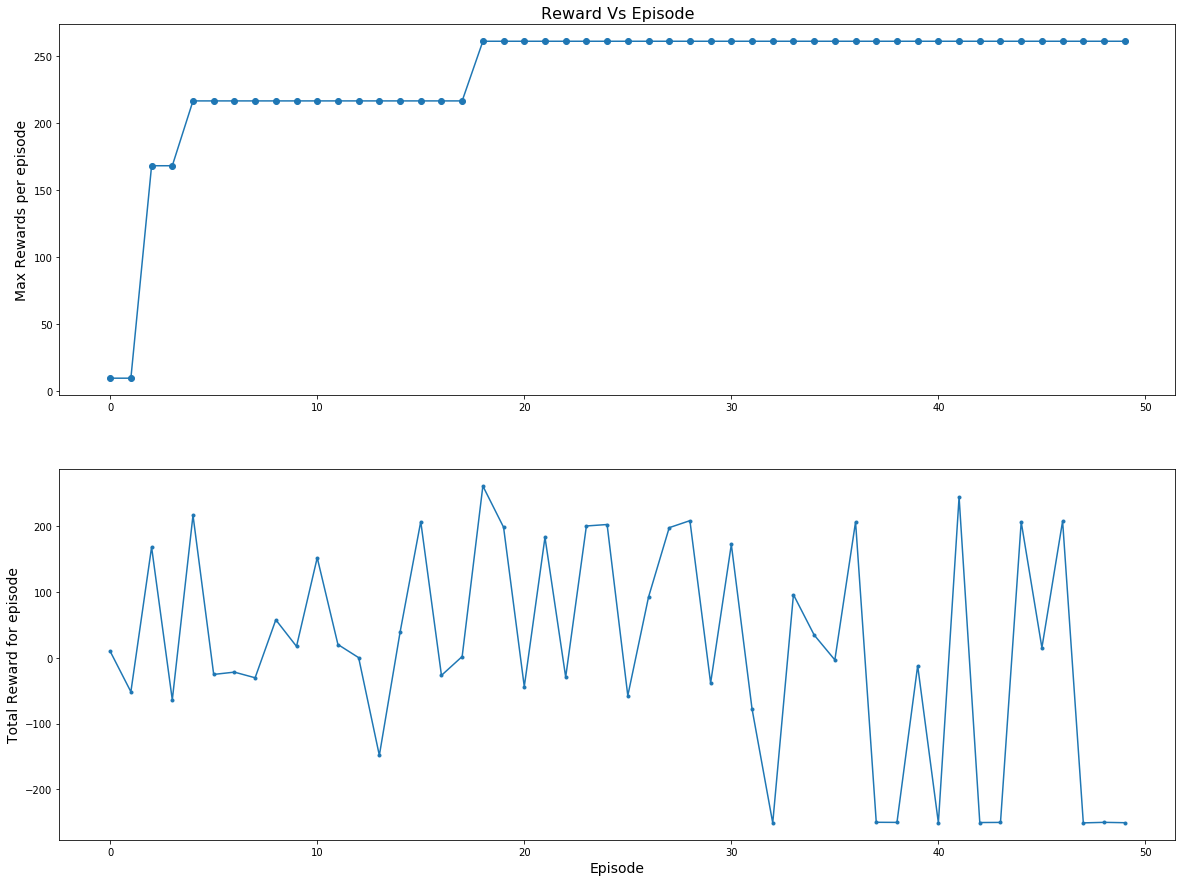

In [4]:
plt.figure(figsize=(20,15))
plt.subplot(2, 1, 1)
plt.plot(total_episode, max_reward_per_episode,  'o-')
plt.title('Reward Vs Episode', fontsize = 16)
plt.ylabel('Max Rewards per episode', fontsize = 14)

plt.subplot(2, 1, 2)
plt.plot( total_episode, reward_per_episode, '.-')
plt.xlabel('Episode', fontsize = 14)
plt.ylabel('Total Reward for episode', fontsize = 14)

***
***

<a id="content8"></a>
## 8. Performance Analysis

   - ### Initial Performane:

![SegmentLocal](images/initial.gif "segment")

   - ### Performance After 100 epochs: 

![SegmentLocal](images/100epochs.gif "segment")

   - ### Performance After 2500 epochs: 

![SegmentLocal](images/2500epochs.gif "segment")

***
***
***

<a id="content9"></a>

## 9. Observation

  - The agent learns to land in the safe zone at the end.
  - Improving the loss function may improve the performance.
  - Bigger network architecture doesn't improve the learning process.
  

***
***
***

<a id="content10"></a>

## 10. Conclusion

<div style="text-align: justify; font-size:14px">
This project implements the very basic idea of reinforcement learning. Throughout my exploration in reinforcement learning, I've realized that there are advanced algorithms that can improve the performance of the agent. In future, I'll try to implement those advanced algorithms to improve the project.    
</div>

***
***
***

## Reference

  - Fundamentals of Deep Learning, Nikhil Buduma
  - Sentdex [Youtube]